# Housing Prices Prediction and Seasonality Analysis - COMPLETE CODE


In [1]:

# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [5]:
#Read Preprocessed Data

# Set the file path for the preprocessed CSV file
input_file_path = "data/processed/bedok_processed.csv"

# Read the CSV file into a DataFrame and parse the timestamp column as datetime
df = pd.read_csv(input_file_path, parse_dates=["timestamp"])

# Sort data by timestamp
df.sort_values("timestamp", inplace=True)

# Set the timestamp as index for time series operations
df.set_index("timestamp", inplace=True)


In [50]:

# Display the first few and last rows
print(df.head())
print(df.tail())

             price_psm  5th_percentile  95th_percentil  log_price  diff_log
timestamp                                                                  
1990-01-01  732.038519      501.679616     1014.206311   6.595833       NaN
1990-02-01  743.112601      465.000000     1089.194915   6.610848  0.015014
1990-03-01  741.736745      488.043478     1029.670330   6.608994 -0.001853
1990-04-01  756.473750      481.492829     1155.371901   6.628668  0.019673
1990-05-01  790.294818      520.984163     1245.829383   6.672406  0.043738
              price_psm  5th_percentile  95th_percentil  log_price  diff_log
timestamp                                                                   
2020-11-01  4700.168245     3751.973684     7058.823529   8.455354 -0.037345
2020-12-01  4830.307963     3769.464512     7183.063328   8.482666  0.027312
2021-01-01  4893.197534     3814.795272     7151.328273   8.495601  0.012936
2021-02-01  4934.151270     3913.032217     7103.629537   8.503936  0.008335
2021-0

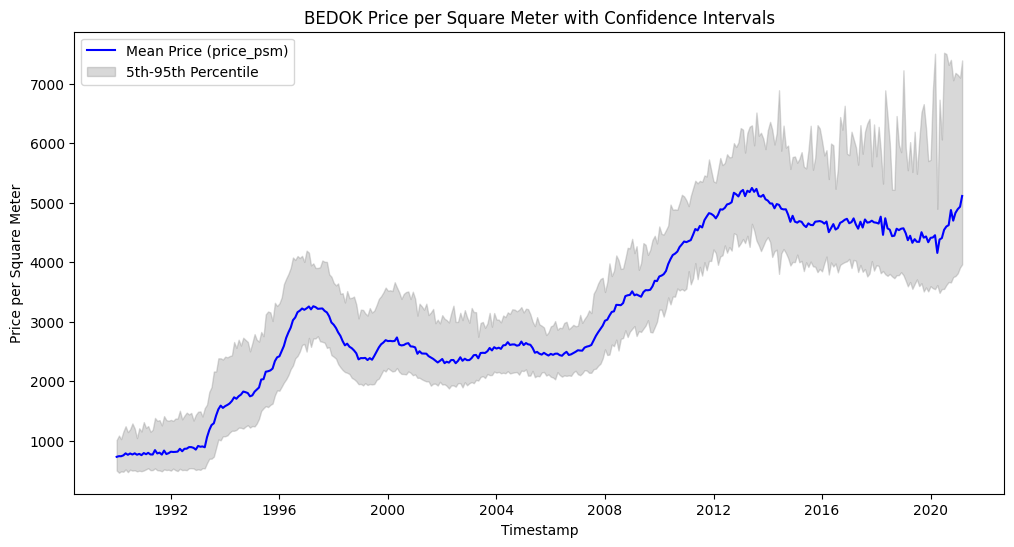

In [7]:
# Plot initial data (with confidence intervals)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["price_psm"], label="Mean Price (price_psm)", color="blue")
plt.fill_between(df.index, df["5th_percentile"], df["95th_percentil"],
                 color="gray", alpha=0.3, label="5th-95th Percentile")
plt.title("BEDOK Price per Square Meter with Confidence Intervals")
plt.xlabel("Timestamp")
plt.ylabel("Price per Square Meter")
plt.legend()
plt.show()


In [8]:
# Stationarity Transformation and Augmented Dickey-Fuller Test
# Use log transformation on the data to transform it to get approximation of continuously compounded returns
# it hhelps to have more white noise like residuals
# The ADF test is then used to check for stationarity.

# Apply logarithmic transformation
df["log_price"] = np.log(df["price_psm"])

# Compute first difference to remove trend
df["diff_log"] = df["log_price"].diff()

# Drop missing values (from differencing)
df_stationary = df["diff_log"].dropna()

# Run the Augmented Dickey-Fuller test
adf_result = adfuller(df_stationary)
print("ADF Statistic: {:.4f}".format(adf_result[0]))
# Interpret the results
if adf_result[1] > 0.05:
    print("The data is not stationary.")
else:
    print("The data is stationary.")


ADF Statistic: -3.7515
The data is stationary.


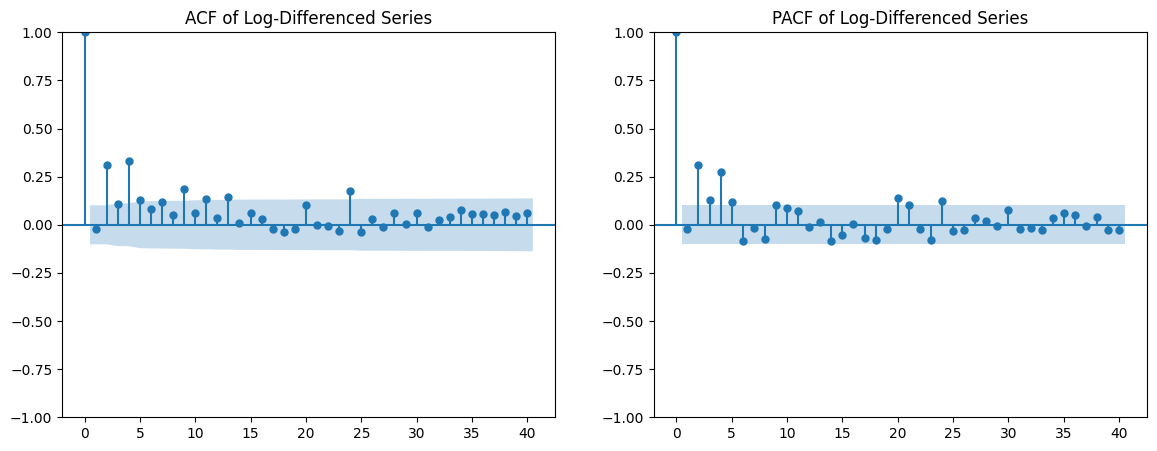

In [9]:
# ## 5. ACF and PACF Analysis
# 
# The ACF and PACF plots help in determining the appropriate ARIMA order.

# %%
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_stationary, lags=40, ax=ax[0])
ax[0].set_title("ACF of Log-Differenced Series")
plot_pacf(df_stationary, lags=40, ax=ax[1])
ax[1].set_title("PACF of Log-Differenced Series")
plt.show()


Long loop to check for best AIC and BIC criterium. It takes a while to run, maybe we dont really need this

In [33]:
p_values = [0, 1, 2, 3, 4, 5]
d_values = [1, 2]
q_values = [0, 1, 2, 3, 4]

best_aic = float("inf")
best_bic = float("inf")
best_order_aic = None
best_order_bic = None
best_model_aic = None
best_model_bic = None

model_results = []  # Will store (p, d, q, AIC, BIC, model_fit)

warnings.filterwarnings("ignore")  # Suppress convergence warnings

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit ARIMA(p, d, q)
                model = ARIMA(df["price_psm"], order=(p, d, q))
                model_fit = model.fit()

                current_aic = model_fit.aic
                current_bic = model_fit.bic

                # Store the result in our list
                model_results.append({
                    "order": (p, d, q),
                    "aic": current_aic,
                    "bic": current_bic,
                    "model": model_fit
                })

                # Update best AIC model
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order_aic = (p, d, q)
                    best_model_aic = model_fit

                # Update best BIC model
                if current_bic < best_bic:
                    best_bic = current_bic
                    best_order_bic = (p, d, q)
                    best_model_bic = model_fit

            except:
                # Some parameter sets may fail to converge
                continue

# Create a DataFrame of all the results
df_results = pd.DataFrame([
    {
        "p": res["order"][0],
        "d": res["order"][1],
        "q": res["order"][2],
        "AIC": res["aic"],
        "BIC": res["bic"]
    }
    for res in model_results
])

# Sort the DataFrame by AIC (ascending)
df_results.sort_values(by="BIC", inplace=True)

print("All tested models sorted by AIC:\n", df_results)
print("\nBest model by AIC:")
print(f"  Order = {best_order_aic}, AIC = {best_aic}")
print(best_model_aic.summary())

print("\nBest model by BIC:")
print(f"  Order = {best_order_bic}, BIC = {best_bic}")
print(best_model_bic.summary())

All tested models sorted by AIC:
     p  d  q          AIC          BIC
16  1  2  1  4122.981228  4134.745963
7   0  2  2  4125.729932  4137.494667
8   0  2  3  4123.249946  4138.936259
26  2  2  1  4123.409471  4139.095785
17  1  2  2  4123.464921  4139.151235
12  1  1  2  4126.315681  4142.012704
21  2  1  1  4126.487340  4142.184363
27  2  2  2  4123.068422  4142.676314
34  3  1  4  4112.561051  4143.955097
9   0  2  4  4125.239130  4144.847022
36  3  2  1  4125.401030  4145.008922
22  2  1  2  4125.583390  4145.204669
13  1  1  3  4125.726974  4145.348253
29  2  2  4  4118.010553  4145.461602
31  3  1  1  4125.928356  4145.549635
59  5  2  4  4107.893273  4147.109057
37  3  2  2  4124.985481  4148.514952
56  5  2  1  4121.524688  4148.975737
18  1  2  3  4129.603567  4149.211459
53  5  1  3  4115.095460  4150.413763
19  1  2  4  4127.249899  4150.779369
46  4  2  1  4127.367903  4150.897374
28  2  2  3  4127.410130  4150.939601
32  3  1  2  4127.580709  4151.126244
41  4  1  1  412

compute the ARIMA model and make prediction. Plot it and also provide error metrics so we can compare other models

In [42]:

# ## 6. ARIMA Model: Training, Forecasting, and Evaluation
# 
# The data is split into training (first 90%) and testing (last 10%). An ARIMA model is trained on the log-transformed series (letting the model handle differencing). Forecasts are made for the test period, and results are plotted along with error metrics.

# %%
# Define the column to model
value_col = "price_psm"

# Split data into training and testing sets
train_size = int(len(df) * 0.90)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# For ARIMA, we model the log-transformed series.
arima_order = (5, 2, 4)  # Adjust ARIMA order as necessary

# Fit ARIMA model on training data using the log-transformed series (model performs differencing internally)
model_arima = ARIMA(train["log_price"], order=arima_order)
model_arima_fit = model_arima.fit()
#print(model_arima_fit.summary())


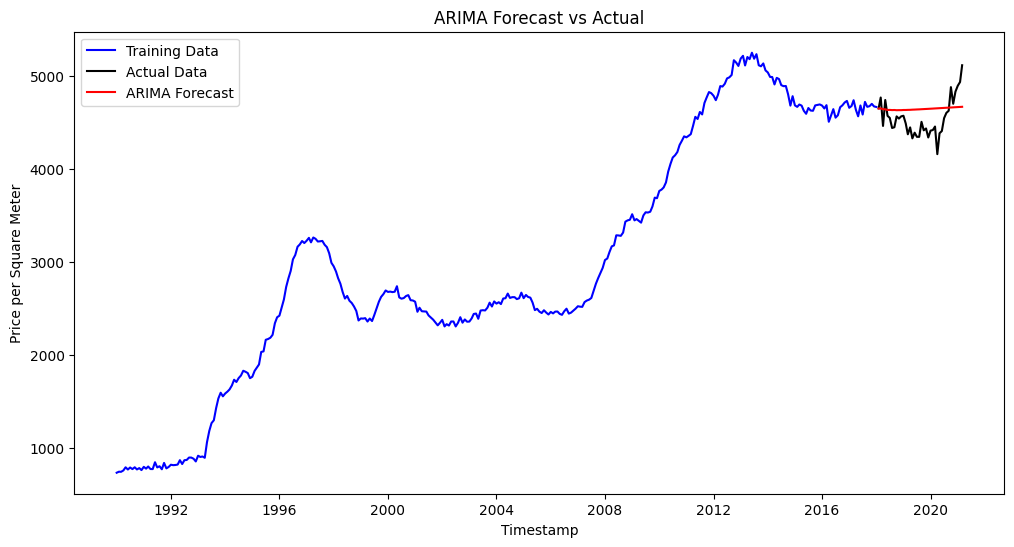

In [43]:

# Forecast the test period
forecast_steps = len(test)
forecast_result = model_arima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Convert forecasts back to original scale
forecast_orig = np.exp(forecast_mean)
conf_int_orig = np.exp(forecast_conf_int)

# Actual values on original scale
actual_orig = test[value_col]

# Plot the forecast vs actual data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[value_col], label="Training Data", color="blue")
plt.plot(test.index, actual_orig, label="Actual Data", color="black")
plt.plot(test.index, forecast_orig, label="ARIMA Forecast", color="red")
#plt.fill_between(test.index, conf_int_orig.iloc[:, 0], conf_int_orig.iloc[:, 1],
#                 color="pink", alpha=0.3, label="95% Confidence Interval")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Timestamp")
plt.ylabel("Price per Square Meter")
plt.legend()
plt.show()


In [44]:

# Compute error metrics
mse_arima = mean_squared_error(actual_orig, forecast_orig)
mae_arima = mean_absolute_error(actual_orig, forecast_orig)
print("ARIMA Model - MSE: {:.4f}, MAE: {:.4f}".format(mse_arima, mae_arima))


ARIMA Model - MSE: 46516.0907, MAE: 186.2929


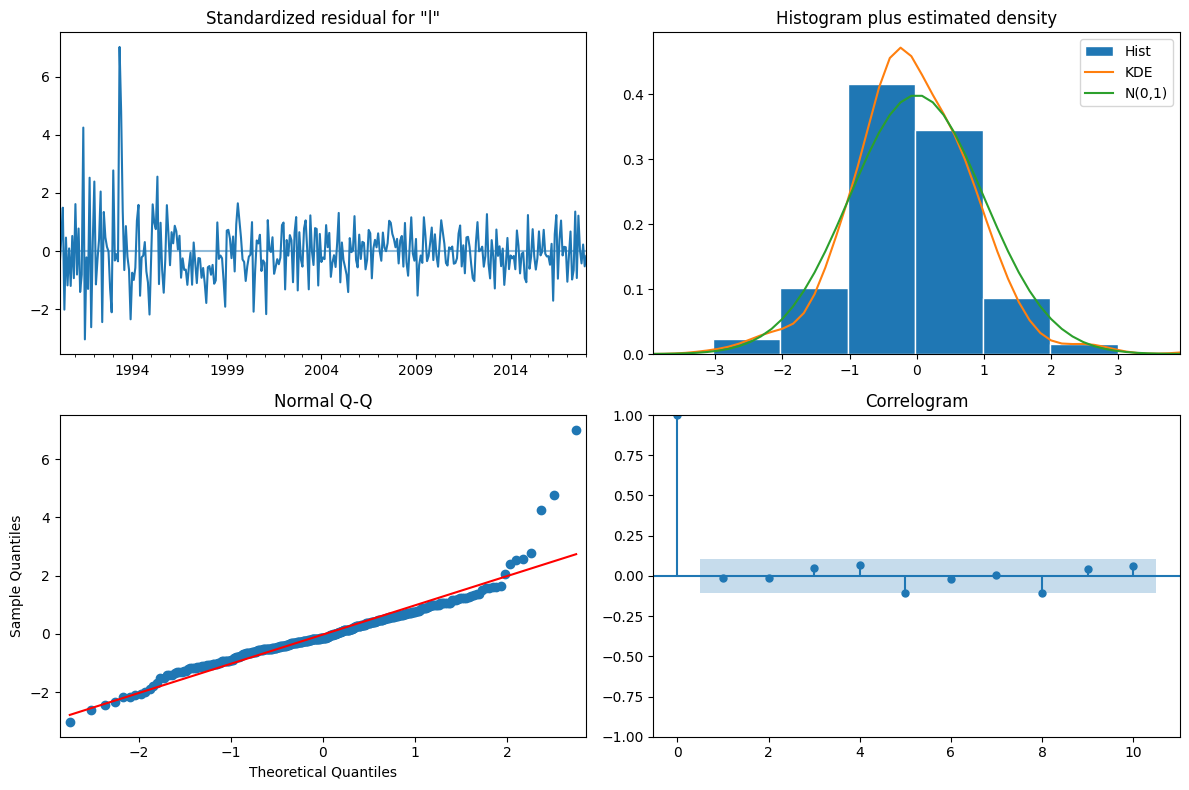

In [45]:
#ARIMA Model Diagnostics
# 
# Display built-in diagnostic plots to check the residuals and validate model assumptions.

# %%
model_arima_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

#as much as I know it looks very decent

## SARIMA
repeat things same as ARIMA

In [47]:

#SARIMA Model Option and Forecasting

# %%
# Specify SARIMA orders: adjust these orders as needed
sarima_order = (5, 2, 4)           # Non-seasonal parameters
seasonal_order = (1, 1, 1, 12)       # suspect seasonality over 12 months

# Fit SARIMA model on training data (using the log-transformed series)
model_sarima = SARIMAX(train["log_price"], order=sarima_order, seasonal_order=seasonal_order)
model_sarima_fit = model_sarima.fit(disp=False)
#print(model_sarima_fit.summary())


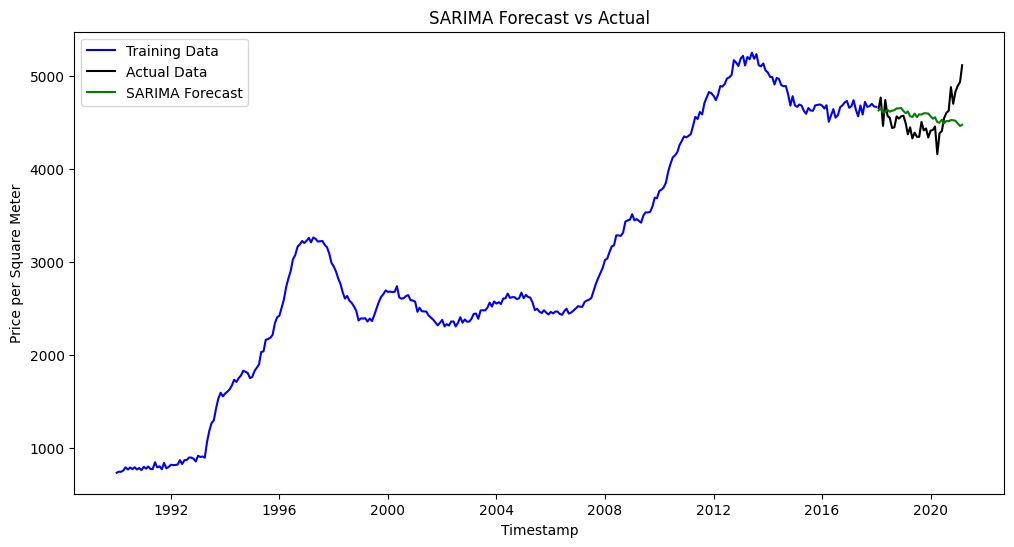

In [48]:

# Forecast with SARIMA
sarima_forecast_result = model_sarima_fit.get_forecast(steps=forecast_steps)
sarima_forecast_mean = sarima_forecast_result.predicted_mean
sarima_conf_int = sarima_forecast_result.conf_int()

# Convert forecasts back to the original scale
sarima_forecast_orig = np.exp(sarima_forecast_mean)
sarima_conf_int_orig = np.exp(sarima_conf_int)

# Plot SARIMA forecast vs actual data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[value_col], label="Training Data", color="blue")
plt.plot(test.index, actual_orig, label="Actual Data", color="black")
plt.plot(test.index, sarima_forecast_orig, label="SARIMA Forecast", color="green")
#plt.fill_between(test.index, sarima_conf_int_orig.iloc[:, 0], sarima_conf_int_orig.iloc[:, 1],
#                 color="lightgreen", alpha=0.3, label="95% Confidence Interval")
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Timestamp")
plt.ylabel("Price per Square Meter")
plt.legend()
plt.show()


In [49]:

# Compute error metrics for SARIMA
mse_sarima = mean_squared_error(actual_orig, sarima_forecast_orig)
mae_sarima = mean_absolute_error(actual_orig, sarima_forecast_orig)
print("SARIMA Model - MSE: {:.4f}, MAE: {:.4f}".format(mse_sarima, mae_sarima))


SARIMA Model - MSE: 48569.4010, MAE: 180.7027


Also make decomposition to be able to see seasonality

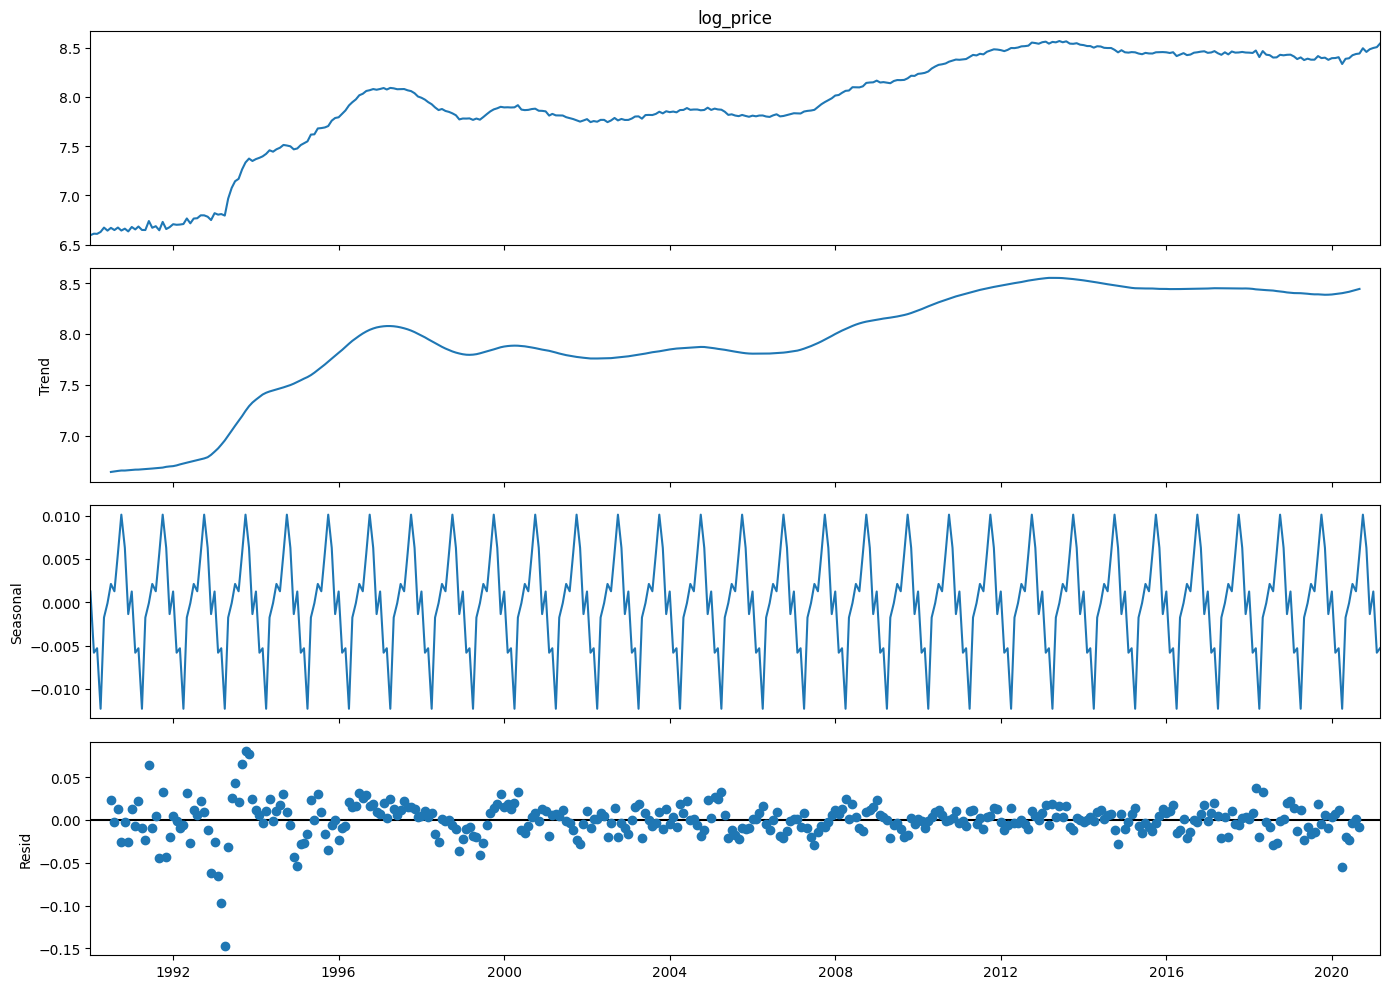

In [28]:

# SARIMA Decomposition)
# 
# Decompose the log-transformed series to visualize trend, seasonality, and residuals. Adjust the seasonal period as needed.

# %%
decomposition = seasonal_decompose(df["log_price"], model="additive", period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## End of Analysis
# 
# This integrated notebook has read the preprocessed BEDOK data and performed data visualization, stationarity testing, ARIMA and SARIMA modeling with forecasts, diagnostic checks, and seasonal decomposition. Adjust model orders and parameters as needed for further experimentation.


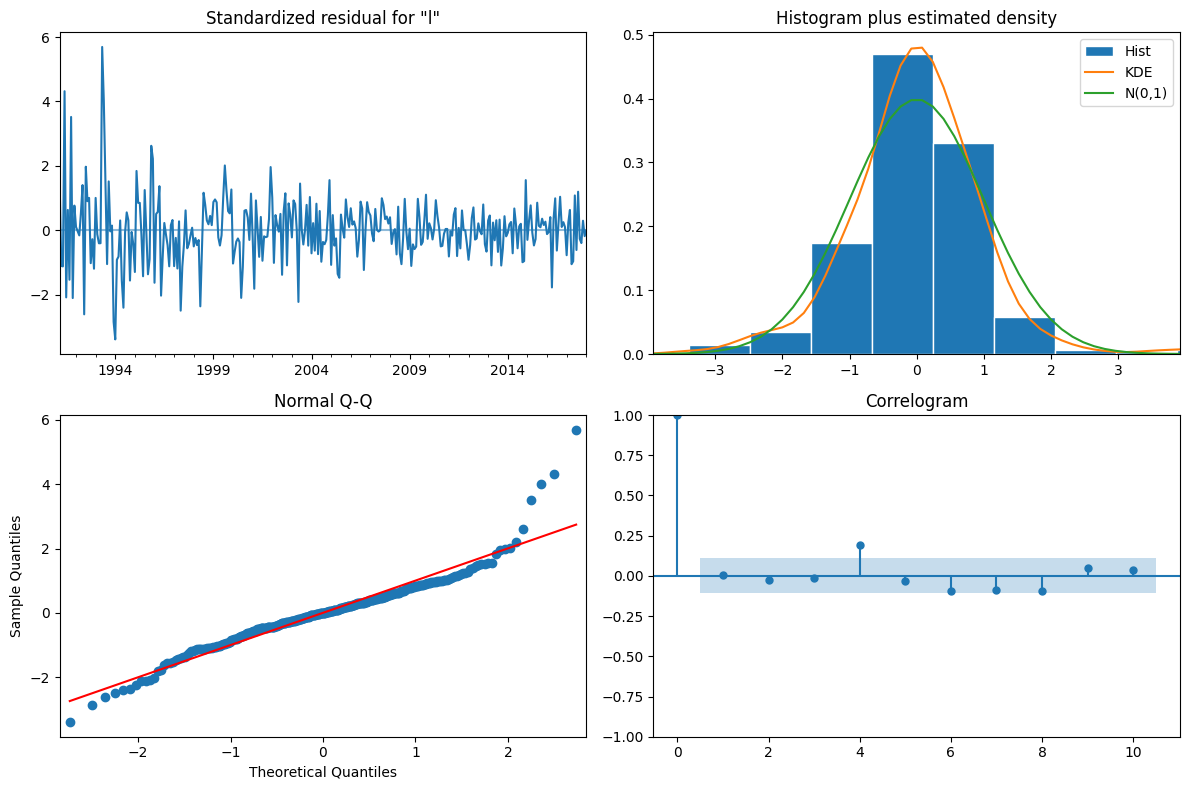

In [29]:
# %%
model_sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()